# Model Building Notebook

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

%matplotlib inline

import pymc3 as pm
import arviz as az

az.rcParams["plot.max_subplots"] = None

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
data = pd.read_csv('prepared_data_2.csv')
data.head()

FLAG_GENDER_MALE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0                 0             1                0             0   
1                 0             1                0             0   
2                 0             0                1             0   
3                 0             0                1             0   
4                 0             0                1             0   

   AMT_INCOME_TOTAL OCCUPATION_TYPE  College_Education  Currently_Married  \
0          130500.0     Accountants                  0                  1   
1          130500.0     Accountants                  0                  1   
2          157500.0        Laborers                  0                  1   
3          157500.0        Laborers                  0                  1   
4          157500.0        Laborers                  0                  1   

  Marriage_Status  Paying_Housing  White_Collar  AGE_YR  YRS_WORKED  \
0         Married               1             1    29.0         3.0   
1         Married               1             1    29.0         3.0   
2         Married               1             0    27.0         4.0   
3         Married               1             0    27.0         4.0   
4         Married               1             0    27.0         4.0   

   target_paid_1  
0              1  
1              1  
2              1  
3              1  
4              1

In [3]:
# Create Clean Copy for Modeling
data_clean = data.copy()

# Transform Hierarchical Variables to Integers
occupation_def = data['OCCUPATION_TYPE'].unique()
data_clean['OCCUPATION_TYPE'].replace(
    occupation_def,
    [x for x in range(len(occupation_def))], 
    inplace=True
)
marriage_def = data['Marriage_Status'].unique()
data_clean['Marriage_Status'].replace(
    marriage_def,
    [x for x in range(len(marriage_def))], 
    inplace=True
)
data_clean.dtypes

FLAG_GENDER_MALE       int64
FLAG_OWN_CAR           int64
FLAG_OWN_REALTY        int64
CNT_CHILDREN           int64
AMT_INCOME_TOTAL     float64
OCCUPATION_TYPE        int64
College_Education      int64
Currently_Married      int64
Marriage_Status        int64
Paying_Housing         int64
White_Collar           int64
AGE_YR               float64
YRS_WORKED           float64
target_paid_1          int64
dtype: object

In [4]:
## For GLM Models ##

data_glm = data_clean.copy()
data_glm['LOG_AMT_INCOME_TOTAL'] = np.log(data_glm['AMT_INCOME_TOTAL'])

In [5]:
## For Manually Build Models ##

# Hierarchical Variables
num_occupation = len(data_clean['OCCUPATION_TYPE'].unique())
occupation = data_clean['OCCUPATION_TYPE'].values
num_marriage = len(data_clean['Marriage_Status'].unique())
marriage = data_clean['Marriage_Status'].values

# Numeric Predictors
children = data_clean['CNT_CHILDREN'].values
income = data_clean['AMT_INCOME_TOTAL'].values
age = data_clean['AGE_YR'].values
yrs_worked = data_clean['YRS_WORKED'].values

# Categorical Predictors
male = data_clean['FLAG_GENDER_MALE'].values
car = data_clean['FLAG_OWN_CAR'].values
realty = data_clean['FLAG_OWN_REALTY'].values
college = data_clean['College_Education'].values
married = data_clean['Currently_Married'].values
pay_housing = data_clean['Paying_Housing'].values
white_collar = data_clean['White_Collar'].values

# Interaction Terms
### TBD ###

# Response Variable
target_paid = data_clean['target_paid_1'].values

## Model 1 - Normal GLM

In [6]:
# Model Predictors 1 - All Except Hierarchical Predictors, Target, and Log Income
predictors1 = [
    x for x in data_glm.columns 
    if x not in ['OCCUPATION_TYPE', 'Marriage_Status', 'target_paid_1', 'LOG_AMT_INCOME_TOTAL']
]

# Where to Start
start_dict1 = {
    'Intercept': 0.,
    'y': 0.
}
for pred in predictors1:
    start_dict1[pred] = 0.

In [7]:
with pm.Model() as log_model_1:
    
    pm.glm.GLM.from_formula(
        formula = f'''target_paid ~ {" + ".join(predictors1)}''', 
        data = data_glm, 
        family = pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


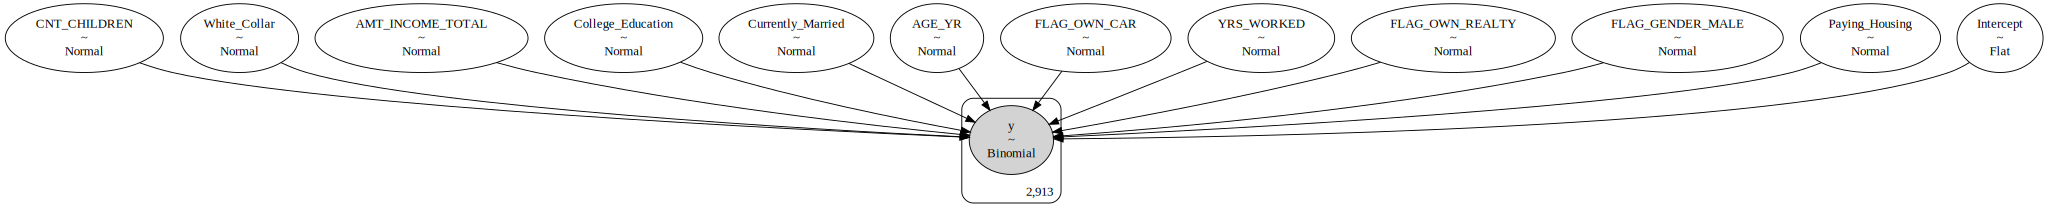

In [8]:
pm.model_to_graphviz(log_model_1)

In [9]:
with log_model_1:
    log_trace_1 = pm.sample(1000, start=start_dict1, chains=8)

C:\Users\Owner\AppData\Local\Temp\ipykernel_10348\3164065839.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  log_trace_1 = pm.sample(1000, start=start_dict1, chains=8)
C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [YRS_WORKED, AGE_YR, White_Collar, Paying_Housing, Currently_Married, College_Education, AMT_INCOME_TOTAL, CNT_CHILDREN, FLAG_OWN_REALTY, FLAG_OWN_CAR, FLAG_GENDER_MALE, Intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 498 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


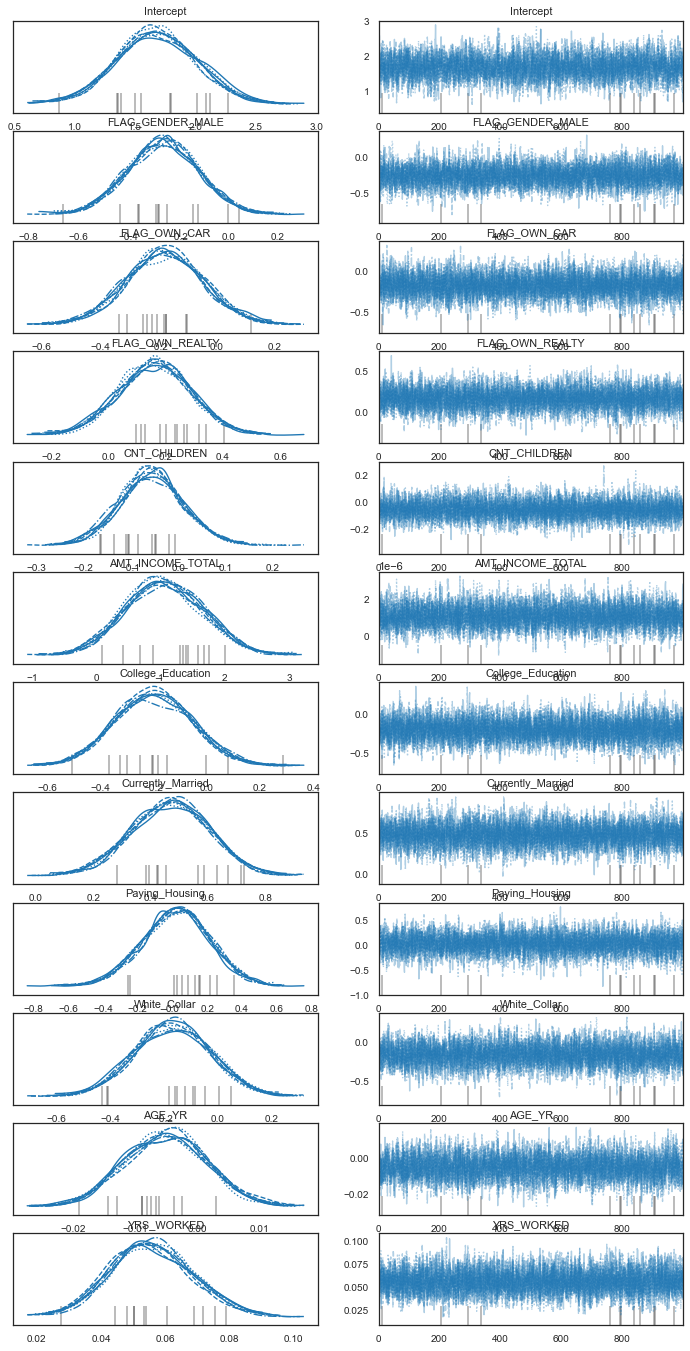

In [10]:
with log_model_1:
    az.plot_trace(log_trace_1)

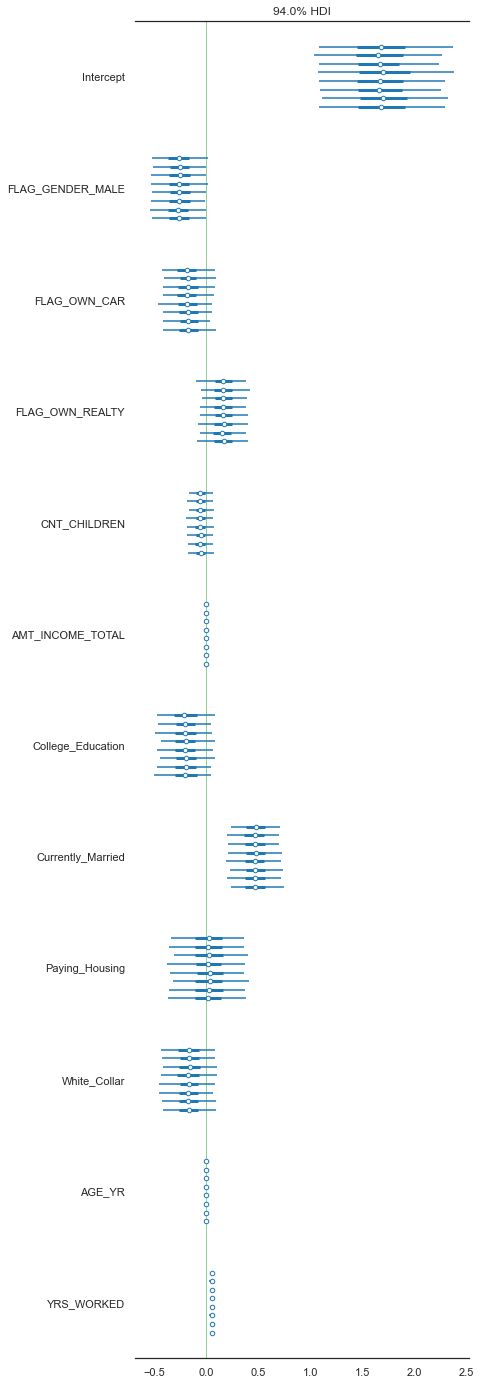

In [11]:
with log_model_1:
    az.plot_forest(log_trace_1, rope=(0, 0))

In [12]:
# Summary Statistics
with log_model_1:
    lm1_sum = pm.summary(log_trace_1)
    
lm1_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept          1.679  0.330   1.069    2.314      0.005    0.004   
FLAG_GENDER_MALE  -0.261  0.142  -0.525    0.008      0.002    0.001   
FLAG_OWN_CAR      -0.177  0.132  -0.416    0.083      0.002    0.001   
FLAG_OWN_REALTY    0.162  0.125  -0.071    0.399      0.002    0.001   
CNT_CHILDREN      -0.056  0.067  -0.183    0.069      0.001    0.001   
AMT_INCOME_TOTAL   0.000  0.000  -0.000    0.000      0.000    0.000   
College_Education -0.199  0.144  -0.473    0.067      0.002    0.001   
Currently_Married  0.469  0.137   0.224    0.735      0.002    0.001   
Paying_Housing     0.022  0.196  -0.339    0.392      0.003    0.002   
White_Collar      -0.167  0.141  -0.435    0.091      0.002    0.001   
AGE_YR            -0.005  0.007  -0.017    0.007      0.000    0.000   
YRS_WORKED         0.056  0.013   0.032    0.080      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
Intercept            3719.0    4476.0    1.0  
FLAG_GENDER_MALE     4900.0    4873.0    1.0  
FLAG_OWN_CAR         6127.0    5143.0    1.0  
FLAG_OWN_REALTY      5719.0    5150.0    1.0  
CNT_CHILDREN         6287.0    5881.0    1.0  
AMT_INCOME_TOTAL     5325.0    4779.0    1.0  
College_Education    6086.0    5317.0    1.0  
Currently_Married    6016.0    5010.0    1.0  
Paying_Housing       5353.0    5419.0    1.0  
White_Collar         4947.0    5446.0    1.0  
AGE_YR               4283.0    5076.0    1.0  
YRS_WORKED           5371.0    5310.0    1.0

## Models 2 - Normal GLM + Log Income

In [13]:
# Model Predictors 1 - All Except Hierarchical Predictors, Target, and Normal Income
predictors2 = [
    x for x in data_glm.columns 
    if x not in ['OCCUPATION_TYPE', 'Marriage_Status', 'target_paid_1', 'AMT_INCOME_TOTAL']
]

# Where to Start
start_dict2 = {
    'Intercept': 0.,
    'y': 0.
}
for pred in predictors2:
    start_dict2[pred] = 0.

In [14]:
with pm.Model() as log_model_2:
    
    pm.glm.GLM.from_formula(
        formula = f'''target_paid ~ {" + ".join(predictors2)}''', 
        data = data_glm, 
        family = pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


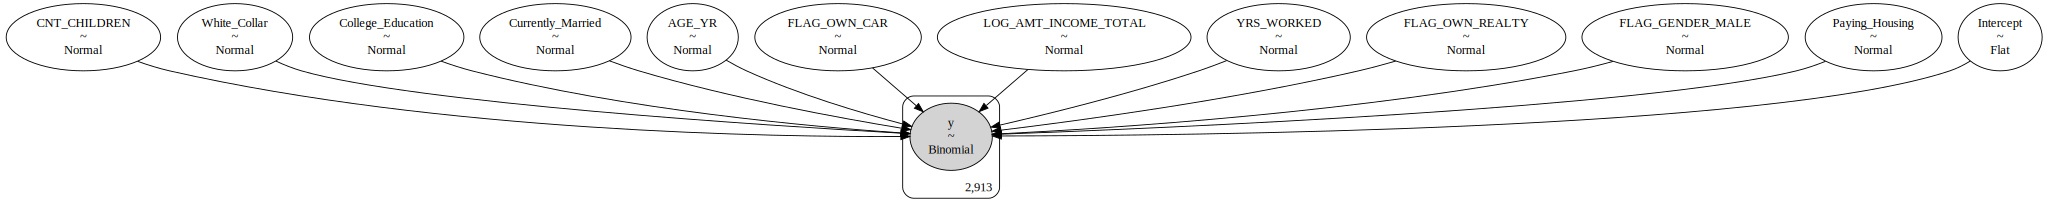

In [15]:
pm.model_to_graphviz(log_model_2)

In [39]:
with log_model_2:
    log_trace_2 = pm.sample(1000, start=start_dict2, chains=8)

C:\Users\Owner\AppData\Local\Temp\ipykernel_10348\1830762541.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  log_trace_2 = pm.sample(1000, start=start_dict2, chains=8)
C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [LOG_AMT_INCOME_TOTAL, YRS_WORKED, AGE_YR, White_Collar, Paying_Housing, Currently_Married, College_Education, CNT_CHILDREN, FLAG_OWN_REALTY, FLAG_OWN_CAR, FLAG_GENDER_MALE, Intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1019 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8873502179862623, but should be close to 0.8. Try to increase the number of tuning steps.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


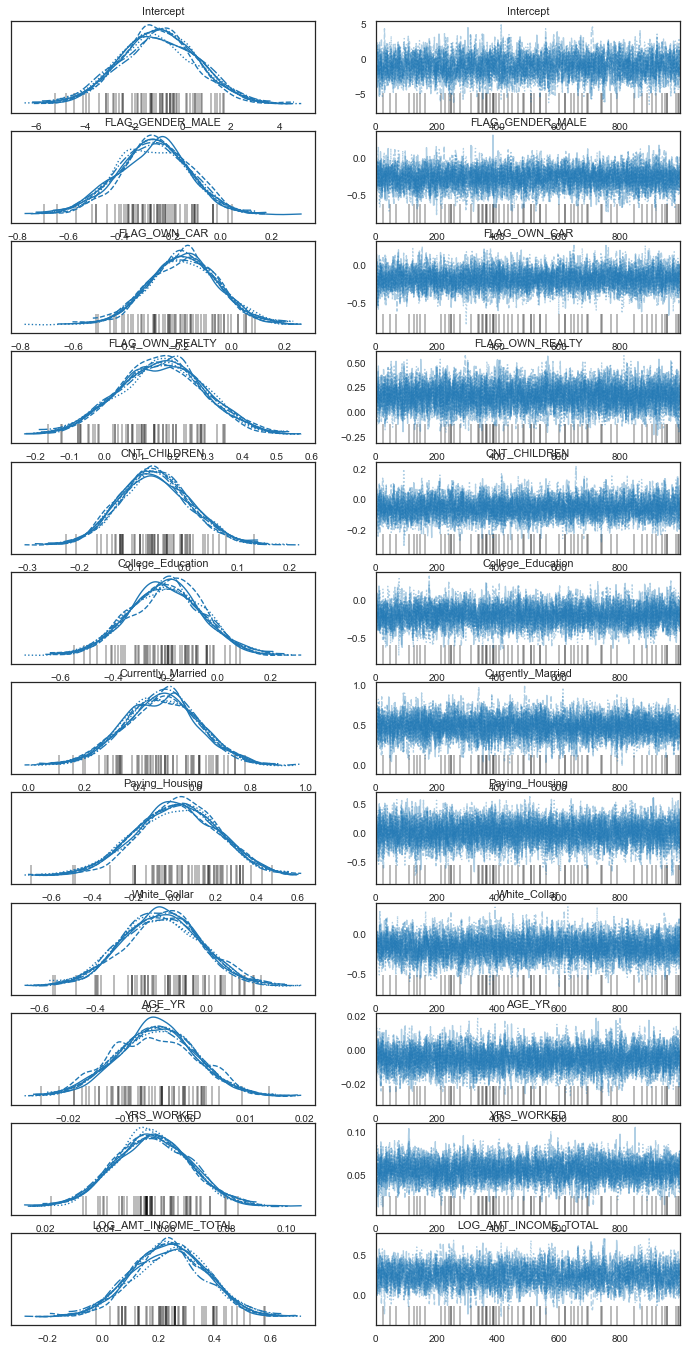

In [40]:
with log_model_2:
    az.plot_trace(log_trace_2)

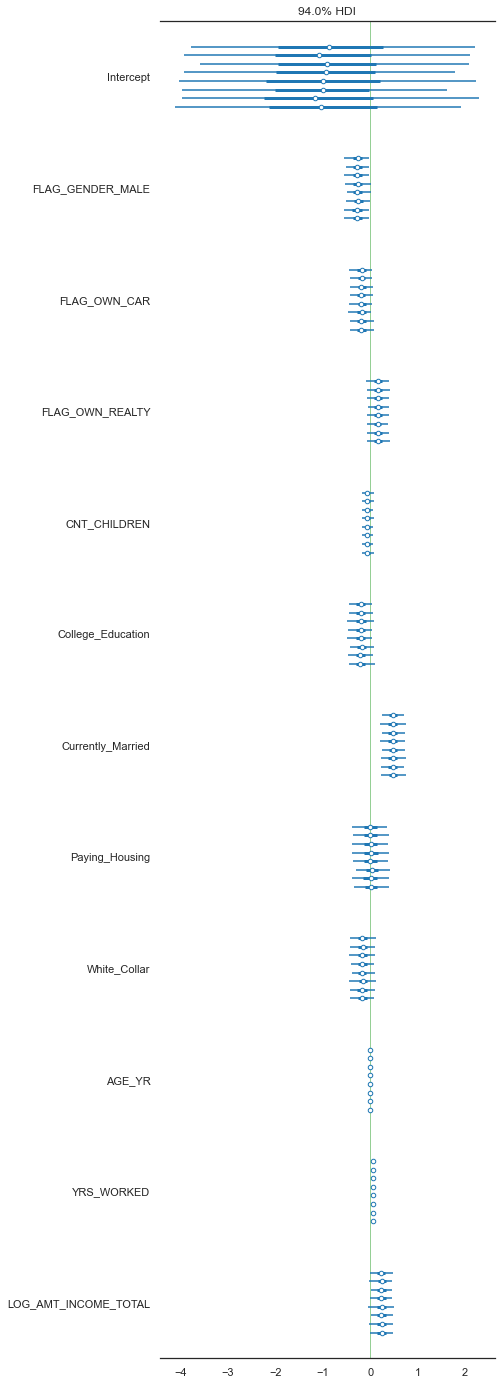

In [41]:
with log_model_2:
    az.plot_forest(log_trace_2, rope=(0, 0))

In [42]:
# Summary Statistics
with log_model_2:
    lm2_sum = pm.summary(log_trace_2)
    
lm2_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept            -0.979  1.606  -3.962    2.070      0.032    0.023   
FLAG_GENDER_MALE     -0.267  0.141  -0.538   -0.011      0.002    0.002   
FLAG_OWN_CAR         -0.181  0.132  -0.426    0.068      0.002    0.002   
FLAG_OWN_REALTY       0.165  0.125  -0.073    0.396      0.002    0.001   
CNT_CHILDREN         -0.056  0.067  -0.177    0.072      0.001    0.001   
College_Education    -0.200  0.141  -0.463    0.066      0.002    0.002   
Currently_Married     0.478  0.136   0.233    0.746      0.002    0.001   
Paying_Housing        0.009  0.203  -0.376    0.382      0.003    0.003   
White_Collar         -0.163  0.142  -0.420    0.111      0.002    0.002   
AGE_YR               -0.005  0.007  -0.018    0.008      0.000    0.000   
YRS_WORKED            0.055  0.012   0.032    0.079      0.000    0.000   
LOG_AMT_INCOME_TOTAL  0.238  0.134  -0.009    0.486      0.003    0.002   

                      ess_bulk  ess_tail  r_hat  
Intercept               2458.0    3706.0    1.0  
FLAG_GENDER_MALE        3612.0    4369.0    1.0  
FLAG_OWN_CAR            4035.0    4109.0    1.0  
FLAG_OWN_REALTY         5127.0    4296.0    1.0  
CNT_CHILDREN            4011.0    4053.0    1.0  
College_Education       4286.0    4194.0    1.0  
Currently_Married       4305.0    4255.0    1.0  
Paying_Housing          4314.0    3642.0    1.0  
White_Collar            3248.0    3774.0    1.0  
AGE_YR                  3370.0    3519.0    1.0  
YRS_WORKED              4360.0    4488.0    1.0  
LOG_AMT_INCOME_TOTAL    2420.0    3759.0    1.0

## Model 3 - Replicate Model 1

In [20]:
with pm.Model() as log_model_3:
    
    ## HyperParameters for Predictors ##
    
    # Intercept
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
    sigma_b0 = pm.HalfCauchy('sigma_b0', beta=1)
    
    # Children
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=1)
    sigma_b1 = pm.HalfCauchy('sigma_b1', beta=1)
    
    # Income
    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=1)
    sigma_b2 = pm.HalfCauchy('sigma_b2', beta=1)
    
    # Age
    mu_b3 = pm.Normal('mu_b3', mu=0, sigma=1)
    sigma_b3 = pm.HalfCauchy('sigma_b3', beta=1)
    
    # Years Worked
    mu_b4 = pm.Normal('mu_b4', mu=0, sigma=1)
    sigma_b4 = pm.HalfCauchy('sigma_b4', beta=1)
    
    # Male
    mu_b5 = pm.Normal('mu_b5', mu=0, sigma=1)
    sigma_b5 = pm.HalfCauchy('sigma_b5', beta=1)
    
    # Car
    mu_b6 = pm.Normal('mu_b6', mu=0, sigma=1)
    sigma_b6 = pm.HalfCauchy('sigma_b6', beta=1)
    
    # Realty
    mu_b7 = pm.Normal('mu_b7', mu=0, sigma=1)
    sigma_b7 = pm.HalfCauchy('sigma_b7', beta=1)
    
    # College
    mu_b8 = pm.Normal('mu_b8', mu=0, sigma=1)
    sigma_b8 = pm.HalfCauchy('sigma_b8', beta=1)
    
    # Married
    mu_b9 = pm.Normal('mu_b9', mu=0, sigma=1)
    sigma_b9 = pm.HalfCauchy('sigma_b9', beta=1)
    
    # Pay Housing
    mu_b10 = pm.Normal('mu_b10', mu=0, sigma=1)
    sigma_b10 = pm.HalfCauchy('sigma_b10', beta=1)
    
    # White Collar
    mu_b11 = pm.Normal('mu_b11', mu=0, sigma=1)
    sigma_b11 = pm.HalfCauchy('sigma_b11', beta=1)    
    
    
    ## Predictors ##
    
    # Intercept
    b0 = pm.Normal('Intercept', mu=mu_b0, sigma=sigma_b0)
    
    # Normal Predictors - Numeric
    b1 = pm.Normal('Children', mu=mu_b1, sigma=sigma_b1)
    b2 = pm.Normal('Income', mu=mu_b2, sigma=sigma_b2)
    b3 = pm.Normal('Age', mu=mu_b3, sigma=sigma_b3)
    b4 = pm.Normal('YearsWorked', mu=mu_b4, sigma=sigma_b4)
    
    # Normal Predictors - Categorical
    b5 = pm.Normal('Male', mu=mu_b5, sigma=sigma_b5)
    b6 = pm.Normal('Car', mu=mu_b6, sigma=sigma_b6)
    b7 = pm.Normal('Realty', mu=mu_b7, sigma=sigma_b7)
    b8 = pm.Normal('College', mu=mu_b8, sigma=sigma_b8)
    b9 = pm.Normal('Married', mu=mu_b9, sigma=sigma_b9)
    b10 = pm.Normal('PayHousing', mu=mu_b10, sigma=sigma_b10)
    b11 = pm.Normal('WhiteCollar', mu=mu_b11, sigma=sigma_b11)
    
    
    ## Model ##
    
    # Regression Equation
    linear_function = b0 + b1*children + b2*income +  b3*age + b4*yrs_worked + b5*male + b6*car + \
                      b7*realty + b8*college + b9*married + b10*pay_housing + b11*white_collar
    
    # Convert to Logistic
    p = pm.math.sigmoid(linear_function)
    y = pm.Bernoulli('y', p, observed=target_paid)

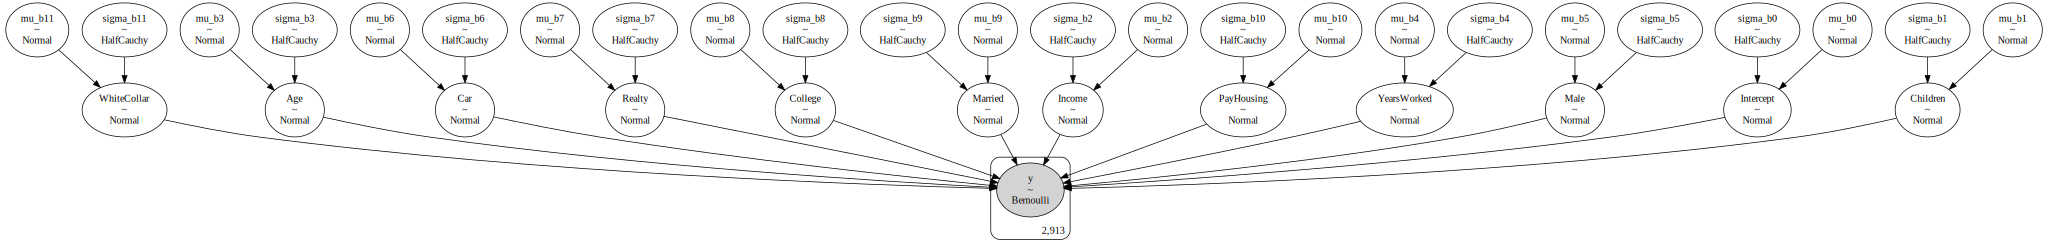

In [21]:
pm.model_to_graphviz(log_model_3)

In [22]:
with log_model_3:
    
    # Increase Target Accept if Lots of Divergences
    step = None
    step = pm.NUTS(target_accept = 0.98) 
    
    # Decrease Cores if Needed
    cores = None
    # cores = 1
    
    # Increase Chains if Desired
    chains = None
    chains = 2
    
    # Number of Burnin and Samples
    samples = 1000
    
    log_trace_3 = pm.sample(samples, tune=samples, chains=chains, step = step, cores=cores)

C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [WhiteCollar, PayHousing, Married, College, Realty, Car, Male, YearsWorked, Age, Income, Children, Intercept, sigma_b11, mu_b11, sigma_b10, mu_b10, sigma_b9, mu_b9, sigma_b8, mu_b8, sigma_b7, mu_b7, sigma_b6, mu_b6, sigma_b5, mu_b5, sigma_b4, mu_b4, sigma_b3, mu_b3, sigma_b2, mu_b2, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 664 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


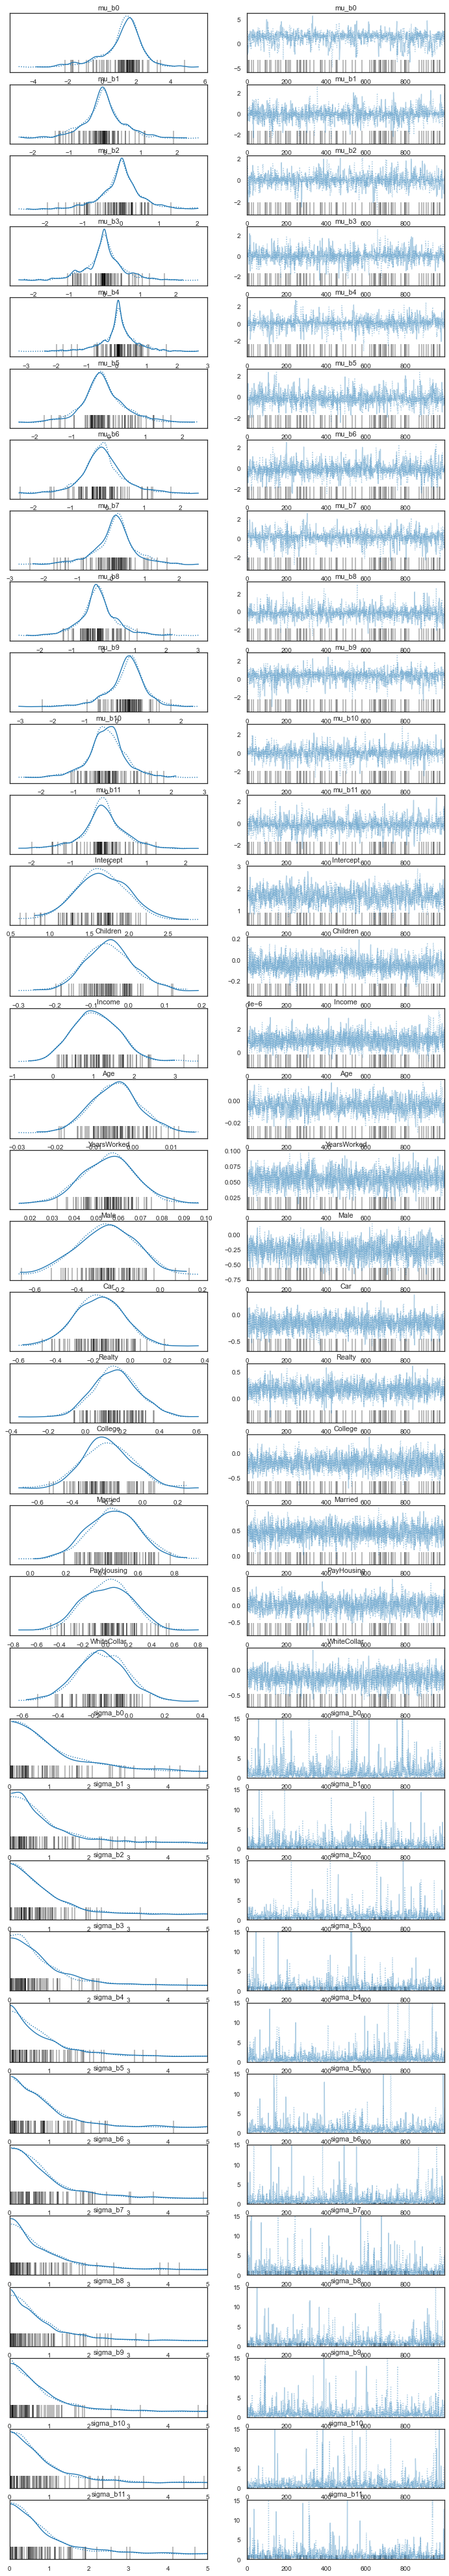

In [23]:
with log_model_3:
    axes3 = az.plot_trace(log_trace_3)
    
    # Edit Display for Certain Distributions
    axes3[24,0].set_xlim(0,5)
    axes3[25,0].set_xlim(0,5)
    axes3[26,0].set_xlim(0,5)
    axes3[27,0].set_xlim(0,5)
    axes3[28,0].set_xlim(0,5)
    axes3[29,0].set_xlim(0,5)
    axes3[30,0].set_xlim(0,5)
    axes3[31,0].set_xlim(0,5)
    axes3[32,0].set_xlim(0,5)
    axes3[33,0].set_xlim(0,5)
    axes3[34,0].set_xlim(0,5)
    axes3[35,0].set_xlim(0,5)

    axes3[24,1].set_ylim(0,15)
    axes3[25,1].set_ylim(0,15)
    axes3[26,1].set_ylim(0,15)
    axes3[27,1].set_ylim(0,15)
    axes3[28,1].set_ylim(0,15)
    axes3[29,1].set_ylim(0,15)
    axes3[30,1].set_ylim(0,15)
    axes3[31,1].set_ylim(0,15)
    axes3[32,1].set_ylim(0,15)
    axes3[33,1].set_ylim(0,15)
    axes3[34,1].set_ylim(0,15)
    axes3[35,1].set_ylim(0,15)

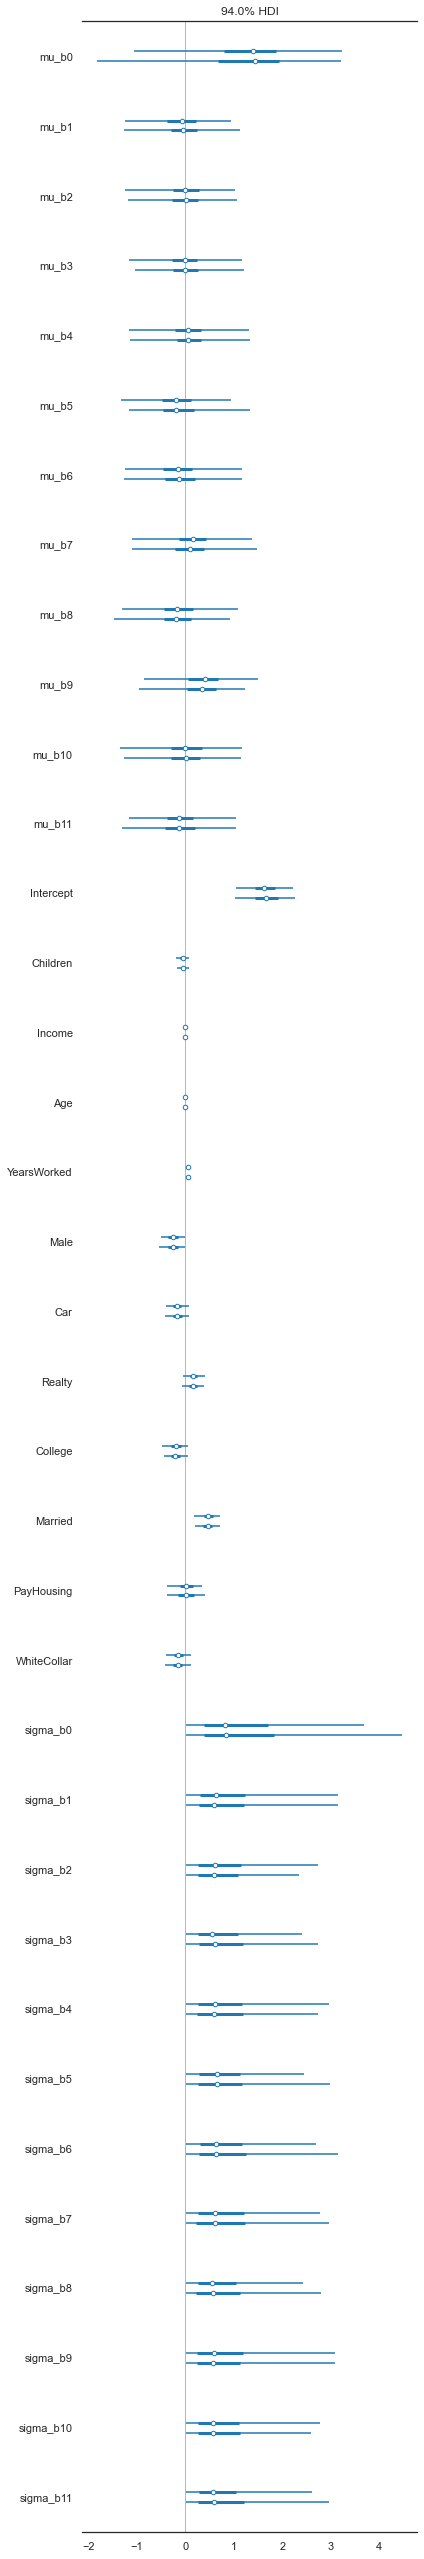

In [24]:
with log_model_3:
    az.plot_forest(log_trace_3, rope=(0, 0))

In [25]:
# Summary Statistics
with log_model_3:
    lm3_sum = pm.summary(log_trace_3)
    
lm3_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0        1.200  1.197  -1.704    3.094      0.059    0.041     522.0   
mu_b1       -0.052  0.592  -1.267    1.027      0.021    0.015     898.0   
mu_b2        0.002  0.559  -1.168    1.105      0.020    0.015     824.0   
mu_b3       -0.011  0.569  -1.176    1.119      0.018    0.014    1075.0   
mu_b4        0.048  0.615  -1.162    1.327      0.020    0.018    1061.0   
mu_b5       -0.153  0.595  -1.364    1.014      0.020    0.014     973.0   
mu_b6       -0.115  0.597  -1.260    1.163      0.018    0.015    1165.0   
mu_b7        0.102  0.623  -1.079    1.455      0.023    0.018     789.0   
mu_b8       -0.137  0.609  -1.310    1.087      0.019    0.015    1069.0   
mu_b9        0.313  0.595  -0.893    1.397      0.019    0.014    1068.0   
mu_b10       0.011  0.616  -1.230    1.237      0.021    0.016     879.0   
mu_b11      -0.121  0.567  -1.246    1.043      0.020    0.016     866.0   
Intercept    1.649  0.327   1.053    2.267      0.011    0.008     951.0   
Children    -0.052  0.068  -0.186    0.071      0.002    0.001    1657.0   
Income       0.000  0.000  -0.000    0.000      0.000    0.000    1605.0   
Age         -0.004  0.006  -0.016    0.008      0.000    0.000     979.0   
YearsWorked  0.056  0.013   0.032    0.080      0.000    0.000    1565.0   
Male        -0.257  0.141  -0.524   -0.005      0.004    0.003    1614.0   
Car         -0.169  0.131  -0.409    0.081      0.003    0.002    1784.0   
Realty       0.165  0.123  -0.074    0.384      0.003    0.002    1790.0   
College     -0.199  0.142  -0.448    0.073      0.004    0.003    1421.0   
Married      0.465  0.142   0.186    0.722      0.003    0.002    1974.0   
PayHousing   0.016  0.208  -0.361    0.397      0.006    0.005    1300.0   
WhiteCollar -0.157  0.141  -0.410    0.121      0.004    0.003    1373.0   
sigma_b0     1.499  2.805   0.012    4.150      0.094    0.066     557.0   
sigma_b1     1.070  1.735   0.006    3.143      0.049    0.035     747.0   
sigma_b2     0.953  1.533   0.006    2.475      0.044    0.031     920.0   
sigma_b3     0.956  1.559   0.007    2.532      0.056    0.039     875.0   
sigma_b4     1.037  2.168   0.009    2.760      0.061    0.043     713.0   
sigma_b5     1.069  3.151   0.008    2.713      0.093    0.066     868.0   
sigma_b6     1.076  2.020   0.007    2.870      0.062    0.044     900.0   
sigma_b7     1.057  1.784   0.006    2.827      0.055    0.039     731.0   
sigma_b8     0.941  1.519   0.007    2.565      0.048    0.034     550.0   
sigma_b9     1.074  2.155   0.008    3.086      0.071    0.050     729.0   
sigma_b10    1.024  1.965   0.007    2.668      0.057    0.040     748.0   
sigma_b11    0.984  1.627   0.007    2.705      0.050    0.036     824.0   

             ess_tail  r_hat  
mu_b0           435.0    1.0  
mu_b1           709.0    1.0  
mu_b2           633.0    1.0  
mu_b3           963.0    1.0  
mu_b4           746.0    1.0  
mu_b5           966.0    1.0  
mu_b6           953.0    1.0  
mu_b7           681.0    1.0  
mu_b8          1040.0    1.0  
mu_b9           814.0    1.0  
mu_b10          825.0    1.0  
mu_b11          818.0    1.0  
Intercept      1249.0    1.0  
Children       1276.0    1.0  
Income          996.0    1.0  
Age            1266.0    1.0  
YearsWorked    1361.0    1.0  
Male           1474.0    1.0  
Car            1188.0    1.0  
Realty         1178.0    1.0  
College        1377.0    1.0  
Married        1421.0    1.0  
PayHousing     1220.0    1.0  
WhiteCollar    1355.0    1.0  
sigma_b0        914.0    1.0  
sigma_b1        572.0    1.0  
sigma_b2        862.0    1.0  
sigma_b3        802.0    1.0  
sigma_b4        681.0    1.0  
sigma_b5        764.0    1.0  
sigma_b6        943.0    1.0  
sigma_b7        840.0    1.0  
sigma_b8        578.0    1.0  
sigma_b9        515.0    1.0  
sigma_b10       805.0    1.0  
sigma_b11       823.0    1.0

## Model 4 - Replicate Model 2

In [33]:
with pm.Model() as log_model_4:
    
    ## HyperParameters for Predictors ##
    
    # Intercept
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=2)
    sigma_b0 = pm.HalfCauchy('sigma_b0', beta=1)
    
    # Children
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=1)
    sigma_b1 = pm.HalfCauchy('sigma_b1', beta=1)
    
    # Income
    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=1)
    sigma_b2 = pm.HalfCauchy('sigma_b2', beta=1)
    
    # Age
    mu_b3 = pm.Normal('mu_b3', mu=0, sigma=1)
    sigma_b3 = pm.HalfCauchy('sigma_b3', beta=1)
    
    # Years Worked
    mu_b4 = pm.Normal('mu_b4', mu=0, sigma=1)
    sigma_b4 = pm.HalfCauchy('sigma_b4', beta=1)
    
    # Male
    mu_b5 = pm.Normal('mu_b5', mu=0, sigma=1)
    sigma_b5 = pm.HalfCauchy('sigma_b5', beta=1)
    
    # Car
    mu_b6 = pm.Normal('mu_b6', mu=0, sigma=1)
    sigma_b6 = pm.HalfCauchy('sigma_b6', beta=1)
    
    # Realty
    mu_b7 = pm.Normal('mu_b7', mu=0, sigma=1)
    sigma_b7 = pm.HalfCauchy('sigma_b7', beta=1)
    
    # College
    mu_b8 = pm.Normal('mu_b8', mu=0, sigma=1)
    sigma_b8 = pm.HalfCauchy('sigma_b8', beta=1)
    
    # Married
    mu_b9 = pm.Normal('mu_b9', mu=0, sigma=1)
    sigma_b9 = pm.HalfCauchy('sigma_b9', beta=1)
    
    # Pay Housing
    mu_b10 = pm.Normal('mu_b10', mu=0, sigma=1)
    sigma_b10 = pm.HalfCauchy('sigma_b10', beta=1)
    
    # White Collar
    mu_b11 = pm.Normal('mu_b11', mu=0, sigma=1)
    sigma_b11 = pm.HalfCauchy('sigma_b11', beta=1)    
    
    
    ## Predictors ##
    
    # Intercept
    b0 = pm.Normal('Intercept', mu=mu_b0, sigma=sigma_b0)
    
    # Normal Predictors - Numeric
    b1 = pm.Normal('Children', mu=mu_b1, sigma=sigma_b1)
    b2 = pm.Normal('LogIncome', mu=mu_b2, sigma=sigma_b2)
    b3 = pm.Normal('Age', mu=mu_b3, sigma=sigma_b3)
    b4 = pm.Normal('YearsWorked', mu=mu_b4, sigma=sigma_b4)
    
    # Normal Predictors - Categorical
    b5 = pm.Normal('Male', mu=mu_b5, sigma=sigma_b5)
    b6 = pm.Normal('Car', mu=mu_b6, sigma=sigma_b6)
    b7 = pm.Normal('Realty', mu=mu_b7, sigma=sigma_b7)
    b8 = pm.Normal('College', mu=mu_b8, sigma=sigma_b8)
    b9 = pm.Normal('Married', mu=mu_b9, sigma=sigma_b9)
    b10 = pm.Normal('PayHousing', mu=mu_b10, sigma=sigma_b10)
    b11 = pm.Normal('WhiteCollar', mu=mu_b11, sigma=sigma_b11)
    
    
    ## Model ##
    
    # Regression Equation
    linear_function = b0 + b1*children + b2*np.log(income) +  b3*age + b4*yrs_worked + b5*male + b6*car + \
                      b7*realty + b8*college + b9*married + b10*pay_housing + b11*white_collar
    
    # Convert to Logistic
    p = pm.math.sigmoid(linear_function)
    y = pm.Bernoulli('y', p, observed=target_paid)

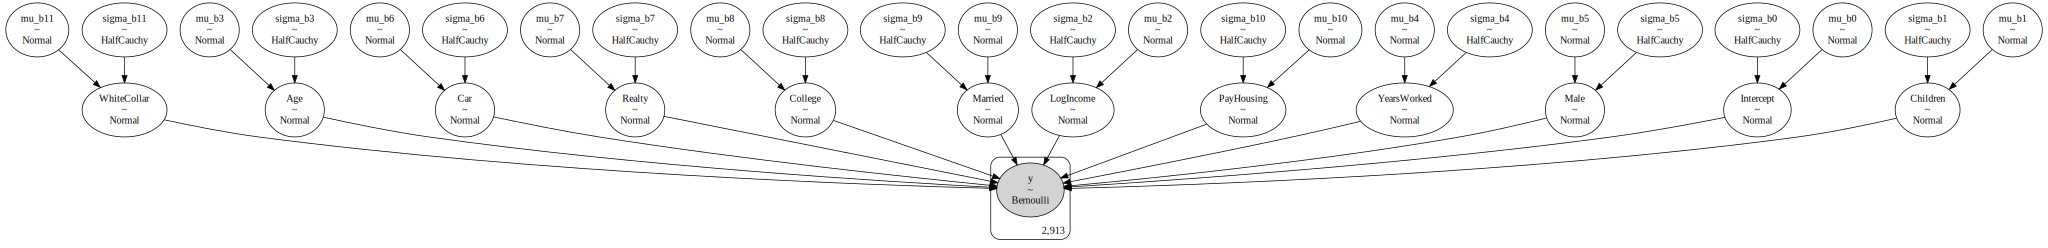

In [34]:
pm.model_to_graphviz(log_model_4)

In [35]:
with log_model_4:
    
    # Increase Target Accept if Lots of Divergences
    step = None
    step = pm.NUTS(target_accept = 0.98) 
    
    # Decrease Cores if Needed
    cores = None
    # cores = 1
    
    # Increase Chains if Desired
    chains = None
    chains = 2
    
    # Number of Burnin and Samples
    samples = 1000
    
    log_trace_4 = pm.sample(samples, tune=samples, chains=chains, step = step, cores=cores)

C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [WhiteCollar, PayHousing, Married, College, Realty, Car, Male, YearsWorked, Age, LogIncome, Children, Intercept, sigma_b11, mu_b11, sigma_b10, mu_b10, sigma_b9, mu_b9, sigma_b8, mu_b8, sigma_b7, mu_b7, sigma_b6, mu_b6, sigma_b5, mu_b5, sigma_b4, mu_b4, sigma_b3, mu_b3, sigma_b2, mu_b2, sigma_b1, mu_b1, sigma_b0, mu_b0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 719 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.


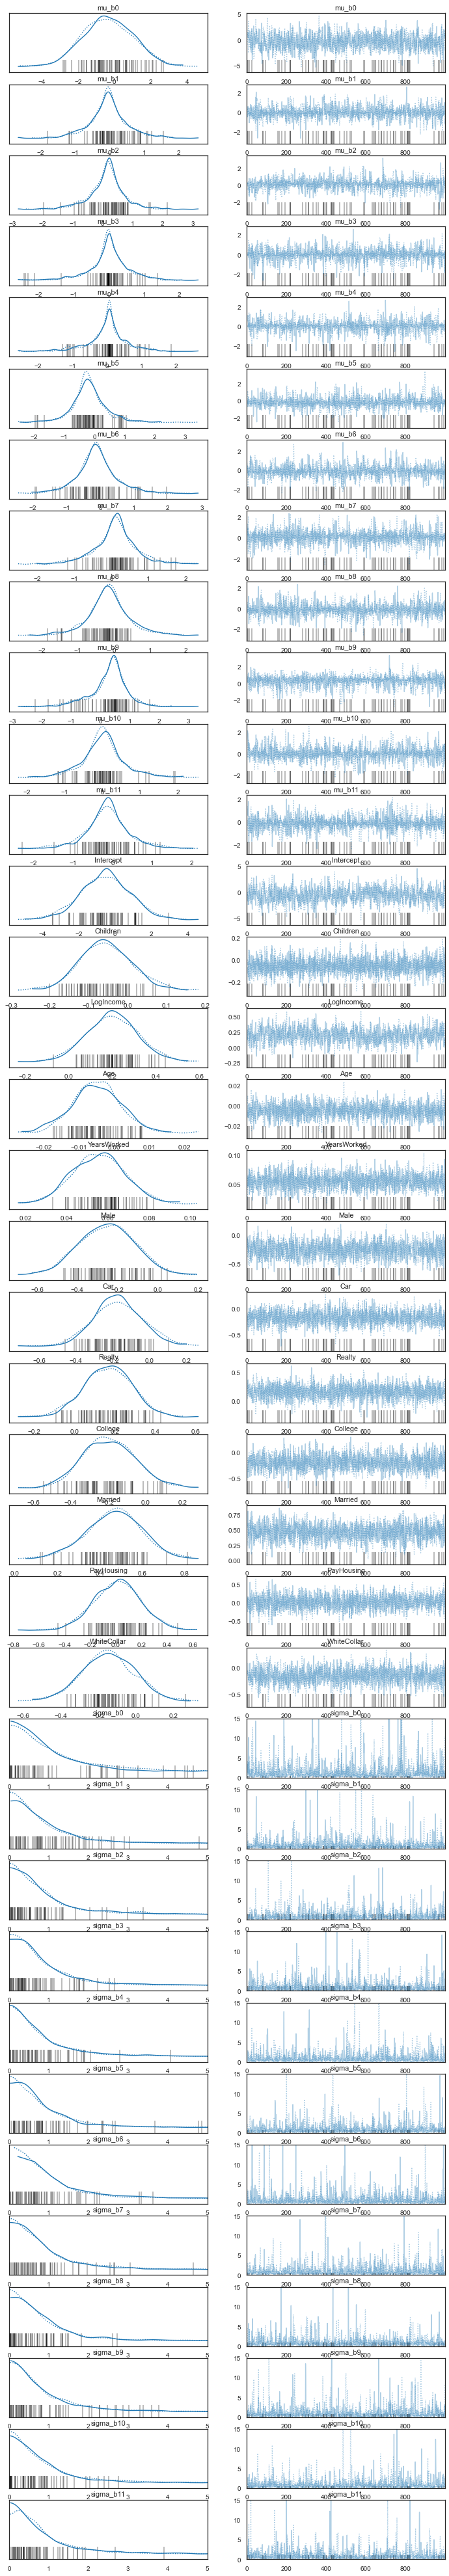

In [36]:
with log_model_4:
    axes4 = az.plot_trace(log_trace_4)
    
    # Edit Display for Certain Distributions
    axes4[24,0].set_xlim(0,5)
    axes4[25,0].set_xlim(0,5)
    axes4[26,0].set_xlim(0,5)
    axes4[27,0].set_xlim(0,5)
    axes4[28,0].set_xlim(0,5)
    axes4[29,0].set_xlim(0,5)
    axes4[30,0].set_xlim(0,5)
    axes4[31,0].set_xlim(0,5)
    axes4[32,0].set_xlim(0,5)
    axes4[33,0].set_xlim(0,5)
    axes4[34,0].set_xlim(0,5)
    axes4[35,0].set_xlim(0,5)
    
    axes4[24,1].set_ylim(0,15)
    axes4[25,1].set_ylim(0,15)
    axes4[26,1].set_ylim(0,15)
    axes4[27,1].set_ylim(0,15)
    axes4[28,1].set_ylim(0,15)
    axes4[29,1].set_ylim(0,15)
    axes4[30,1].set_ylim(0,15)
    axes4[31,1].set_ylim(0,15)
    axes4[32,1].set_ylim(0,15)
    axes4[33,1].set_ylim(0,15)
    axes4[34,1].set_ylim(0,15)
    axes4[35,1].set_ylim(0,15)

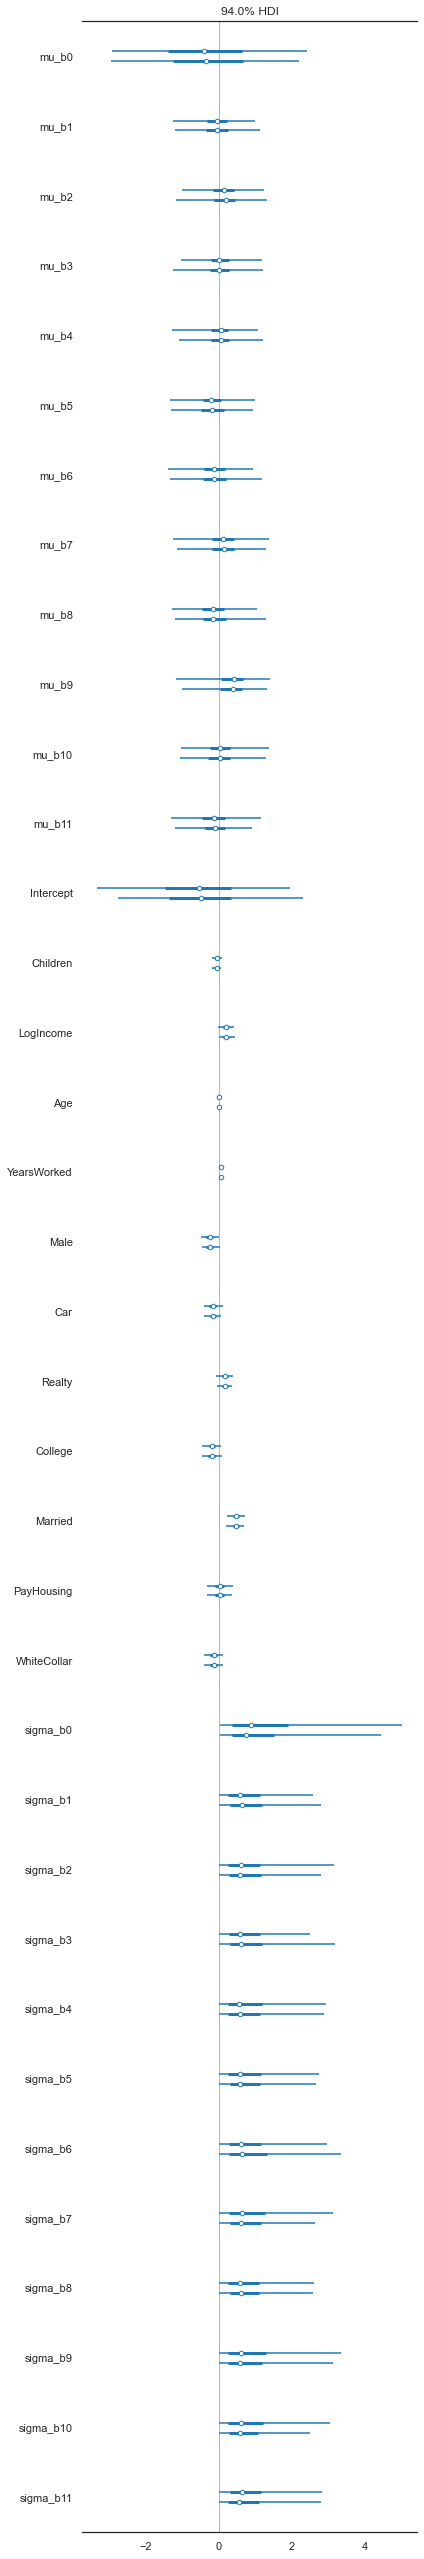

In [37]:
with log_model_4:
    az.plot_forest(log_trace_4, rope=(0, 0))

In [38]:
# Summary Statistics
with log_model_4:
    lm4_sum = pm.summary(log_trace_4)
    
lm4_sum

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_b0       -0.350  1.446  -2.918    2.353      0.048    0.034     910.0   
mu_b1       -0.039  0.570  -1.291    1.007      0.017    0.013    1243.0   
mu_b2        0.132  0.603  -1.189    1.235      0.019    0.016     970.0   
mu_b3       -0.005  0.577  -1.243    1.098      0.017    0.014    1243.0   
mu_b4        0.002  0.570  -1.191    1.162      0.018    0.015    1032.0   
mu_b5       -0.167  0.590  -1.353    0.953      0.017    0.016    1450.0   
mu_b6       -0.107  0.601  -1.206    1.227      0.021    0.016     901.0   
mu_b7        0.112  0.621  -1.156    1.394      0.018    0.016    1262.0   
mu_b8       -0.140  0.596  -1.342    1.084      0.018    0.016    1169.0   
mu_b9        0.297  0.632  -1.102    1.367      0.022    0.015     962.0   
mu_b10       0.035  0.592  -1.057    1.358      0.021    0.018     878.0   
mu_b11      -0.126  0.569  -1.347    0.980      0.014    0.015    1666.0   
Intercept   -0.530  1.376  -3.335    1.854      0.052    0.037     688.0   
Children    -0.056  0.069  -0.177    0.083      0.001    0.001    2552.0   
LogIncome    0.199  0.117  -0.023    0.419      0.004    0.003     682.0   
Age         -0.005  0.007  -0.018    0.008      0.000    0.000    1634.0   
YearsWorked  0.056  0.013   0.031    0.079      0.000    0.000    1919.0   
Male        -0.252  0.136  -0.511   -0.012      0.004    0.003    1459.0   
Car         -0.170  0.131  -0.422    0.068      0.003    0.002    1861.0   
Realty       0.165  0.121  -0.073    0.373      0.003    0.002    1884.0   
College     -0.194  0.141  -0.451    0.077      0.003    0.002    1669.0   
Married      0.466  0.131   0.216    0.715      0.003    0.002    1686.0   
PayHousing   0.014  0.185  -0.327    0.368      0.004    0.004    2164.0   
WhiteCollar -0.146  0.141  -0.413    0.110      0.004    0.003    1378.0   
sigma_b0     1.520  2.505   0.013    4.780      0.085    0.060     511.0   
sigma_b1     0.997  1.676   0.005    2.677      0.047    0.034    1108.0   
sigma_b2     0.971  1.311   0.006    3.000      0.043    0.030     642.0   
sigma_b3     0.968  1.400   0.005    2.741      0.039    0.027    1068.0   
sigma_b4     1.076  3.467   0.005    2.922      0.130    0.092     790.0   
sigma_b5     0.964  1.513   0.005    2.661      0.048    0.034     643.0   
sigma_b6     1.349  7.436   0.004    3.170      0.229    0.163     910.0   
sigma_b7     1.028  1.793   0.004    2.981      0.060    0.046     864.0   
sigma_b8     0.948  1.411   0.004    2.568      0.037    0.026     735.0   
sigma_b9     1.091  1.844   0.005    3.271      0.058    0.041     873.0   
sigma_b10    0.987  1.861   0.006    2.736      0.053    0.037     724.0   
sigma_b11    0.988  1.511   0.010    2.813      0.047    0.033     681.0   

             ess_tail  r_hat  
mu_b0          1219.0   1.00  
mu_b1           909.0   1.00  
mu_b2          1003.0   1.00  
mu_b3          1157.0   1.00  
mu_b4           807.0   1.00  
mu_b5          1235.0   1.00  
mu_b6           838.0   1.00  
mu_b7           783.0   1.00  
mu_b8           917.0   1.00  
mu_b9          1048.0   1.00  
mu_b10          746.0   1.00  
mu_b11         1254.0   1.01  
Intercept       856.0   1.00  
Children       1396.0   1.00  
LogIncome       799.0   1.00  
Age            1349.0   1.00  
YearsWorked    1545.0   1.00  
Male           1434.0   1.00  
Car            1559.0   1.01  
Realty         1263.0   1.00  
College        1508.0   1.00  
Married        1263.0   1.00  
PayHousing     1408.0   1.00  
WhiteCollar    1201.0   1.00  
sigma_b0        801.0   1.00  
sigma_b1        808.0   1.00  
sigma_b2        487.0   1.00  
sigma_b3        980.0   1.00  
sigma_b4        817.0   1.00  
sigma_b5        648.0   1.00  
sigma_b6        916.0   1.00  
sigma_b7        838.0   1.00  
sigma_b8        598.0   1.00  
sigma_b9        885.0   1.00  
sigma_b10       699.0   1.00  
sigma_b11       738.0   1.01

## Model 5 - Adding Interactions